# Multi-fidelity Multi-Objective optimization  

In this tutorial notebook we demonstrate how to perform multi-objective multi-fidelity optimization in BoTorch using the multi-fidelity Hypervolume Knowledge Gradient (MF-HVKG) [3] and a method called Multi-Objective Multi-Fidelity (MOMF) [1]. 

MF-HVKG performs one-step lookahead: it operates under the assumption that we can make one additional observation, and after receiving that additional observation, we will select the Pareto set of optimal designs. HVKG seeks to select the design `x` to evaluate that maximizes the value of information about the Pareto set by maximizing the hypervolume under the posterior mean (conditional on receiving on new observation for the design `x`).

MOMF is an alternative approach that introduces an additional "fidelity objective" that is optimized along with the problem objectives. This fidelity objective can be thought of as a trust objective that rewards the optimization when going to higher fidelity. Thus, the MOMF explicitly optimizes for getting more high-fidelity (trustworthy) data while taking into account the higher computational costs associated with it.

HVKG is generally more cost efficient [3], since it explicitly targets the goal of MF optimization: select design points and fidelities that enable identifying about the Pareto Frontier at the target fidelity in a cost-aware fashion. MOMF will typically result in faster candidate generation. If the application is high-throughput and requires fast candidate generation, MOMF will be preferable. Otherwise, MF-HVKG will likely give better sample efficiency and performance [3].

In this tutorial, we will optimize a synthetic function that is a modified multi-fidelity Branin-Currin [1]. This is a 3-dimesional, bi-objective problem with one of the input dimensions being the fidelity. For the MOMF, this results in a 3-objective problem since it also takes the fidelity objective into account. In this case the fidelity objective is a linear function of fidelity, $ f(s)=s$, where $s$ is the fidelity. The MOMF algorithm can accept any discrete or continuous cost functions as an input. In this example, we choose an exponential dependency of the form $C(s)=\exp(4.8s)$. The goal of the optimization is to find the Pareto front, which is a trade-off solution set for Multi-objective problems, at the highest fidelity. 

Note: pymoo is an optional dependency that is used for determining the Pareto set of optimal designs under the model posterior mean using NSGA-II (which is not a sample efficient method, but sample efficiency is not critical for this step). If pymoo is not available, the Pareto set of optimal designs is selected from a discrete set. This will work okay for low-dim (e.g. 
 dimensions) problems, but in general NSGA-II will yield far better results.

[1] [Irshad, Faran, Stefan Karsch, and Andreas Döpp. "Expected hypervolume improvement for simultaneous multi-objective and multi-fidelity optimization." arXiv preprint arXiv:2112.13901 (2021).](https://arxiv.org/abs/2112.13901)

[2] [S. Daulton, M. Balandat, and E. Bakshy. Parallel Bayesian Optimization of Multiple Noisy Objectives. NeurIPS, 2021.](https://proceedings.neurips.cc/paper/2021/hash/11704817e347269b7254e744b5e22dac-Abstract.html)

[3] [S. Daulton, M. Balandat, and E. Bakshy. Hypervolume Knowledge Gradient for Multi-Objective Bayesian Optimization with Partial Information. ICML, 2023.](https://proceedings.mlr.press/v202/daulton23a.html)

In [1]:
import os
from typing import Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch

### Set dtype and device 
Setting up the global variable that determine the device to run the optimization. The optimization is much faster when it runs on GPU.

In [2]:
tkwargs = {  # Tkwargs is a dictionary contaning data about data type and data device
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Define the problem and optimization settings

In [3]:
from botorch.test_functions.multi_objective_multi_fidelity import MOMFBraninCurrin

BC = MOMFBraninCurrin(negate=True).to(**tkwargs)
dim_x = BC.dim
dim_y = BC.num_objectives

ref_point = torch.zeros(dim_y, **tkwargs)


BATCH_SIZE = 1  # For batch optimization, BATCH_SIZE should be greater than 1
# This evaluation budget is set to be very low to make the notebook run fast. This should be much higher.
EVAL_BUDGET = 2.05  # in terms of the number of full-fidelity evaluations
n_INIT = 2  # Initialization budget in terms of the number of full-fidelity evaluations
# Number of Monte Carlo samples, used to approximate MOMF
MC_SAMPLES = 8 if SMOKE_TEST else 128
# Number of restart points for multi-start optimization
NUM_RESTARTS = 2 if SMOKE_TEST else 10
# Number of raw samples for initial point selection heuristic
RAW_SAMPLES = 4 if SMOKE_TEST else 512

standard_bounds = torch.zeros(2, dim_x, **tkwargs)
standard_bounds[1] = 1
# mapping from index to target fidelity (highest fidelity)
target_fidelities = {2: 1.0}

### Helper functions to define Cost 

The cost_func function returns an exponential cost from the fidelity. The cost_callable is a wrapper around it that takes care of the input output shapes. This is provided to the MF algorithms which inversely weight the expected utility by the cost.

In [4]:
from math import exp
def cost_func(x):
    """A simple exponential cost function."""
    exp_arg = torch.tensor(4.8, **tkwargs)
    val = torch.exp(exp_arg * x)
    return val


# Displaying the min and max costs for this optimization
print(f"Min Cost: {cost_func(0)}")
print(f"Max Cost: {cost_func(1)}")

def cost_callable(X: torch.Tensor) -> torch.Tensor:
    r"""Wrapper for the cost function that takes care of shaping
    input and output arrays for interfacing with cost_func.
    This is passed as a callable function to MOMF.

    Args:
        X: A `batch_shape x q x d`-dim Tensor
    Returns:
        Cost `batch_shape x q x m`-dim Tensor of cost generated
        from fidelity dimension using cost_func.
    """

    return cost_func(X[..., -1:])

Min Cost: 1.0
Max Cost: 121.51041751873485


### Model Initialization 
We use a multi-output SingleTaskGP to model the problem with a homoskedastic Gaussian likelihood with an inferred noise level. 
The model is initialized with random points, where the fidelity is sampled from a probability distribution with a PDF that is inversely proportional to the cost: $p(s)=C(s)^{-1}$. The initialization is given a budget equivalent to 2 full-fidelity evaluations.

In [5]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.priors import GammaPrior
from botorch.utils.transforms import normalize


def inv_transform(u):
    # define inverse transform to sample from the probability distribution with
    # PDF proportional to 1/(c(x))
    # u is a uniform(0,1) rv
    return (
        5 / 24 * torch.log(-exp(24 / 5) / (exp(24 / 5) * u - u - exp(24 / 5)))
    )


def gen_init_data(n: int):
    r"""
    Generates the initial data. Sample fidelities inversely proportional to cost.
    """
    # total cost budget is n
    train_x = torch.empty(
        0, BC.bounds.shape[1], dtype=BC.bounds.dtype, device=BC.bounds.device
    )
    total_cost = 0
    # assume target fidelity is 1
    total_cost_limit = (
        n
        * cost_callable(
            torch.ones(
                1, BC.bounds.shape[1], dtype=BC.bounds.dtype, device=BC.bounds.device
            )
        ).item()
    )
    while total_cost < total_cost_limit:
        new_x = torch.rand(
            1, BC.bounds.shape[1], dtype=BC.bounds.dtype, device=BC.bounds.device
        )
        new_x[:, -1] = inv_transform(new_x[:, -1])
        total_cost += cost_callable(new_x)
        train_x = torch.cat([train_x, new_x], dim=0)
    train_x = train_x[:-1]
    train_obj = BC(train_x)
    return train_x, train_obj


def initialize_model(train_x, train_obj, state_dict=None):
    """Initializes a ModelList with Matern 5/2 Kernel and returns the model and its MLL.
    
    Note: a batched model could also be used here.
    """
    models = []
    for i in range(train_obj.shape[-1]):
        m = SingleTaskGP(
            train_x,
            train_obj[:, i : i + 1],
            train_Yvar=torch.full_like(train_obj[:, i : i + 1], 1e-6),
            outcome_transform=Standardize(m=1),
            covar_module=ScaleKernel(
                MaternKernel(
                    nu=2.5,
                    ard_num_dims=train_x.shape[-1],
                    lengthscale_prior=GammaPrior(2.0, 2.0),
                ),
                outputscale_prior=GammaPrior(2.0, 0.15),
            ),
        )
        models.append(m)
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    if state_dict is not None:
        model.load_state_dict(state_dict=state_dict)
    return mll, model

### Helper function to optimize acquisition function 
This is a helper function that initializes, optimizes the acquisition function MOMF and returns the new_x and new_obj. The problem is called from within this helper function.

A simple initialization heuristic is used to select the 20 restart initial locations from a set of 1024 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

In [6]:
from botorch.acquisition.multi_objective.multi_fidelity import MOMF
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.utils.transforms import unnormalize


dim_y_momf = dim_y + 1  # Output Dimesnion for MOMF optimization
ref_point_momf = torch.zeros(dim_y_momf, **tkwargs)

def fid_obj(X: torch.Tensor) -> torch.Tensor:
    """
    A Fidelity Objective that can be thought of as a trust objective.
    Higher Fidelity simulations are rewarded as being more
    trustworthy. Here we consider just a linear fidelity objective.
    """
    fid_obj = 1 * X[..., -1]
    return fid_obj


def get_objective_momf(x: torch.Tensor) -> torch.Tensor:
    """Wrapper around the Objective function to take care of fid_obj stacking"""
    y = BC(x)  # The Branin-Currin is called
    fid = fid_obj(x)  # Getting the fidelity objective values
    fid_out = fid.unsqueeze(-1)
    # Concatenating objective values with fid_objective
    y_out = torch.cat([y, fid_out], -1)
    return y_out


def optimize_MOMF_and_get_obs(
    model: SingleTaskGP,
    train_obj: torch.Tensor,
    sampler: SobolQMCNormalSampler,
    ref_point: torch.Tensor,
    standard_bounds: torch.Tensor,
    BATCH_SIZE: int,
    cost_call: Callable[[torch.Tensor], torch.Tensor],
):
    """
    Wrapper to call MOMF and optimizes it in a sequential greedy
    fashion returning a new candidate and evaluation
    """
    partitioning = FastNondominatedPartitioning(
        ref_point=ref_point, Y=train_obj
    )
    acq_func = MOMF(
        model=model,
        ref_point=ref_point,  # use known reference point
        partitioning=partitioning,
        sampler=sampler,
        cost_call=cost_call,
    )
    # Optimization
    candidates, vals = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )
    # if the AF val is 0, set the fidelity parameter to zero
    if vals.item() == 0.0:
        candidates[:, -1] = 0.0
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=standard_bounds)
    new_obj = get_objective_momf(new_x)
    return new_x, new_obj

### Define helper functions for MF-HVKG

`get_current_value` optimizes the current posterior mean at the full fidelity to determine the hypervolume under the current model.

`optimize_HVKG_and_get_obs` creates the MF-HVKG acquisition function, optimizes it, and returns the new design and corresponding observation.


In [7]:
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.multi_objective.hypervolume_knowledge_gradient import (
    _get_hv_value_function,
    qMultiFidelityHypervolumeKnowledgeGradient,
)
from botorch.acquisition.utils import project_to_target_fidelity
from botorch.models.deterministic import GenericDeterministicModel
from torch import Tensor

NUM_INNER_MC_SAMPLES = 32
NUM_PARETO = 10
NUM_FANTASIES = 8


def get_current_value(
    model: SingleTaskGP,
    ref_point: torch.Tensor,
    bounds: torch.Tensor,
    normalized_target_fidelities: Dict[int, float],
):
    """Helper to get the hypervolume of the current hypervolume
    maximizing set.
    """
    fidelity_dims, fidelity_targets = zip(*normalized_target_fidelities.items())
    # optimize
    non_fidelity_dims = list(set(range(dim_x)) - set(fidelity_dims))
    curr_val_acqf = FixedFeatureAcquisitionFunction(
        acq_function=_get_hv_value_function(
            model=model,
            ref_point=ref_point,
            sampler=SobolQMCNormalSampler(
                sample_shape=torch.Size([NUM_INNER_MC_SAMPLES]),
                resample=False,
                collapse_batch_dims=True,
            ),
            use_posterior_mean=True,
        ),
        d=dim_x,
        columns=fidelity_dims,
        values=fidelity_targets,
    )
    # optimize
    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds[:, non_fidelity_dims],
        q=NUM_PARETO,
        num_restarts=1,
        raw_samples=1024,
        return_best_only=True,
        options={"nonnegative": True},
    )
    return current_value


normalized_target_fidelities = {}
for idx, fidelity in target_fidelities.items():
    lb = standard_bounds[0, idx].item()
    ub = standard_bounds[1, idx].item()
    normalized_target_fidelities[idx] = (fidelity - lb) / (ub - lb)
project_d = dim_x


def project(X: Tensor) -> Tensor:

    return project_to_target_fidelity(
        X=X,
        d=project_d,
        target_fidelities=normalized_target_fidelities,
    )


def optimize_HVKG_and_get_obs(
    model: SingleTaskGP,
    ref_point: torch.Tensor,
    standard_bounds: torch.Tensor,
    BATCH_SIZE: int,
    cost_call: Callable[[torch.Tensor], torch.Tensor],
):
    """Utility to initialize and optimize HVKG."""
    cost_model = GenericDeterministicModel(cost_call)
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)
    current_value = get_current_value(
        model=model,
        ref_point=ref_point,
        bounds=standard_bounds,
        normalized_target_fidelities=normalized_target_fidelities,
    )

    acq_func = qMultiFidelityHypervolumeKnowledgeGradient(
        model=model,
        ref_point=ref_point,  # use known reference point
        num_fantasies=NUM_FANTASIES,
        num_pareto=NUM_PARETO,
        current_value=current_value,
        cost_aware_utility=cost_aware_utility,
        target_fidelities=normalized_target_fidelities,
        project=project,
    )
    # Optimization
    candidates, vals = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=1,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5},
    )
    # if the AF val is 0, set the fidelity parameter to zero
    if vals.item() == 0.0:
        candidates[:, -1] = 0.0
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=BC.bounds)
    new_obj = BC(new_x)
    return new_x, new_obj

### Define helper functions for MF-HVKG

We run MOMF to optimize the multi-fidelity versions of the Branin-Currin functions. The optimization loop works in the following sequence. 

1. At the start with an initialization equivalent to 2 full fidelity evaluations.
2. The models are used to generate an acquisition function that is optimized to select new input parameters
3. The objective function is evaluated at the suggested new_x and returns a new_obj.
4. The models are updated with the new points and then are used again to make the next prediction.

The evaluation budget for the optimization is set to 4 full fidelity evaluations.

Note: running this takes some time.


In [8]:
from botorch import fit_gpytorch_mll

In [9]:
# Intializing train_x to zero
verbose = False
torch.manual_seed(0)
train_x_momf, _ = gen_init_data(n_INIT)
train_obj_momf = get_objective_momf(train_x_momf)
# Generate Sampler
momf_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# run N_BATCH rounds of BayesOpt after the initial random batch
iteration = 0
total_cost = cost_callable(train_x_momf).sum().item()
while total_cost < EVAL_BUDGET * cost_func(1):
    if verbose:
        print(f"cost: {total_cost}")

    # reinitialize the models so they are ready for fitting on next iteration
    mll, model = initialize_model(normalize(train_x_momf, BC.bounds), train_obj_momf)

    fit_gpytorch_mll(mll=mll)  # Fit the model

    # optimize acquisition functions and get new observations
    new_x, new_obj = optimize_MOMF_and_get_obs(
        model=model,
        train_obj=train_obj_momf,
        sampler=momf_sampler,
        ref_point=ref_point_momf,
        standard_bounds=standard_bounds,
        BATCH_SIZE=BATCH_SIZE,
        cost_call=cost_callable,
    )
    # Updating train_x and train_obj
    train_x_momf = torch.cat([train_x_momf, new_x], dim=0)
    train_obj_momf = torch.cat([train_obj_momf, new_obj], dim=0)
    iteration += 1
    total_cost += cost_callable(new_x).sum().item()

/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


### Run MF-HVKG

In [10]:
torch.manual_seed(0)
train_x_kg, train_obj_kg = gen_init_data(n_INIT)
MF_n_INIT = train_x_kg.shape[0]
iteration = 0
total_cost = cost_callable(train_x_kg).sum().item()
while total_cost < EVAL_BUDGET * cost_func(1):
    if verbose:
        print(f"cost: {total_cost}")

    # reinitialize the models so they are ready for fitting on next iteration
    mll, model = initialize_model(normalize(train_x_kg, BC.bounds), train_obj_kg)

    fit_gpytorch_mll(mll=mll)  # Fit the model
    # optimize acquisition functions and get new observations
    new_x, new_obj = optimize_HVKG_and_get_obs(
        model=model,
        ref_point=ref_point,
        standard_bounds=standard_bounds,
        BATCH_SIZE=BATCH_SIZE,
        cost_call=cost_callable,
    )
    # Updating train_x and train_obj
    train_x_kg = torch.cat([train_x_kg, new_x], dim=0)
    train_obj_kg = torch.cat([train_obj_kg, new_obj], dim=0)
    iteration += 1
    total_cost += cost_callable(new_x).sum().item()

/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: 

### Result:  Evaluating the Pareto front at the highest fidelity using NSGA-II on the posterior mean


In [11]:
from botorch.utils.multi_objective.pareto import (
    _is_non_dominated_loop,
    is_non_dominated,
)
from gpytorch import settings

try:
    from pymoo.optimize import minimize
    
    # Note: These are the pymoo 0.6+ imports, if you happen to be stuck on 
    # an older pymoo version you need to replace them with the ones below.
    from pymoo.algorithms.moo.nsga2 import NSGA2
    from pymoo.core.problem import Problem
    from pymoo.termination.max_gen import MaximumGenerationTermination
    
    # from pymoo.algorithms.nsga2 import NSGA2
    # from pymoo.model.problem import Problem
    # from pymoo.util.termination.max_gen import MaximumGenerationTermination
    
    
    def get_pareto(
        model,
        non_fidelity_indices,
        project,
        population_size=250,
        max_gen=100,
        is_mf_model=True,
    ):
        """Optimize the posterior mean using NSGA-II."""
        tkwargs = {
            "dtype": BC.ref_point.dtype,
            "device": BC.ref_point.device,
        }
        dim = len(non_fidelity_indices)

        class PosteriorMeanPymooProblem(Problem):
            def __init__(self):
                super().__init__(
                    n_var=dim,
                    n_obj=BC.num_objectives,
                    type_var=np.double,
                )
                self.xl = np.zeros(dim)
                self.xu = np.ones(dim)

            def _evaluate(self, x, out, *args, **kwargs):
                X = torch.from_numpy(x).to(**tkwargs)
                if is_mf_model:
                    X = project(X)
                with torch.no_grad():
                    with settings.cholesky_max_tries(9):
                        # eval in batch mode
                        y = model.posterior(X.unsqueeze(-2)).mean.squeeze(-2)
                out["F"] = -y.cpu().numpy()

        pymoo_problem = PosteriorMeanPymooProblem()
        algorithm = NSGA2(
            pop_size=population_size,
            eliminate_duplicates=True,
        )
        res = minimize(
            pymoo_problem,
            algorithm,
            termination=MaximumGenerationTermination(max_gen),
            seed=0,  # fix seed
            verbose=False,
        )
        X = torch.tensor(
            res.X,
            **tkwargs,
        )
        # project to full fidelity
        if is_mf_model:
            if project is not None:
                X = project(X)
        # determine Pareto set of designs under model
        with torch.no_grad():
            preds = model.posterior(X.unsqueeze(-2)).mean.squeeze(-2)
        pareto_mask = is_non_dominated(preds)
        X = X[pareto_mask]
        # evaluate Pareto set of designs on true function and compute hypervolume
        if not is_mf_model:
            X = project(X)
        X = unnormalize(X, BC.bounds)
        Y = BC(X)
        # compute HV
        partitioning = FastNondominatedPartitioning(ref_point=BC.ref_point, Y=Y)
        return partitioning.compute_hypervolume().item()

except ImportError:
    NUM_DISCRETE_POINTS = 100 if SMOKE_TEST else 100000
    CHUNK_SIZE = 512

    def get_pareto(
        model,
        non_fidelity_indices,
        project,
        population_size=250,
        max_gen=100,
        is_mf_model=True,
    ):
        """Optimize the posterior mean over a discrete set."""
        tkwargs = {
            "dtype": BC.ref_point.dtype,
            "device": BC.ref_point.device,
        }
        dim_x = BC.dim

        discrete_set = torch.rand(NUM_DISCRETE_POINTS, dim_x - 1, **tkwargs)
        if is_mf_model:
            discrete_set = project(discrete_set)
        discrete_set[:, -1] = 1.0  # set to target fidelity
        with torch.no_grad():
            preds_list = []
            for start in range(0, NUM_DISCRETE_POINTS, CHUNK_SIZE):
                preds = model.posterior(
                    discrete_set[start : start + CHUNK_SIZE].unsqueeze(-2)
                ).mean.squeeze(-2)
                preds_list.append(preds)
            preds = torch.cat(preds_list, dim=0)
            pareto_mask = _is_non_dominated_loop(preds)
            pareto_X = discrete_set[pareto_mask]
        if not is_mf_model:
            pareto_X = project(pareto_X)
        pareto_X = unnormalize(pareto_X, BC.bounds)
        Y = BC(pareto_X)
        # compute HV
        partitioning = FastNondominatedPartitioning(ref_point=BC.ref_point, Y=Y)
        return partitioning.compute_hypervolume().item()

## Evaluate MF-HVKG

We evaluate performance after every 5 evaluations (this is to speed things up, since there are many observations).

In [12]:
hvs_kg = []
costs = []
for i in range(MF_n_INIT, train_x_kg.shape[0] + 1, 5):

    mll, model = initialize_model(
        normalize(train_x_kg[:i], BC.bounds), train_obj_kg[:i]
    )
    fit_gpytorch_mll(mll)
    hypervolume = get_pareto(
        model, project=project, non_fidelity_indices=[0, 1]
    )
    hvs_kg.append(hypervolume)
    costs.append(cost_callable(train_x_kg[:i]).sum().item())

/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


## Evaluate MOMF

We evaluate performance after every evaluation (there are not as many evaluations since MOMF queries higher fidelities more frequently).

In [13]:
hvs_momf = []
costs_momf = []
for i in range(MF_n_INIT, train_x_momf.shape[0] + 1):

    mll, model = initialize_model(
        normalize(train_x_momf[:i], BC.bounds), train_obj_momf[:i, :2]
    )
    fit_gpytorch_mll(mll)
    hypervolume = get_pareto(model, project=project, non_fidelity_indices=[0, 1])
    hvs_momf.append(hypervolume)
    costs_momf.append(cost_callable(train_x_momf[:i]).sum().item())

/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
/Users/balandat/Code/gpytorch/gpytorch/likelihoods/noise_models.py:150: 

### Plot log inference hypervolume regret (under the model) vs cost

Log inference hypervolume regret, defined as the logarithm of the difference between the maximum hypervolume dominated by the Pareto frontier and the hypervolume corresponding to the Pareto set identified by each algorithm, is a performance evaluation criterion for multi-information source multi-objective optimization [3].

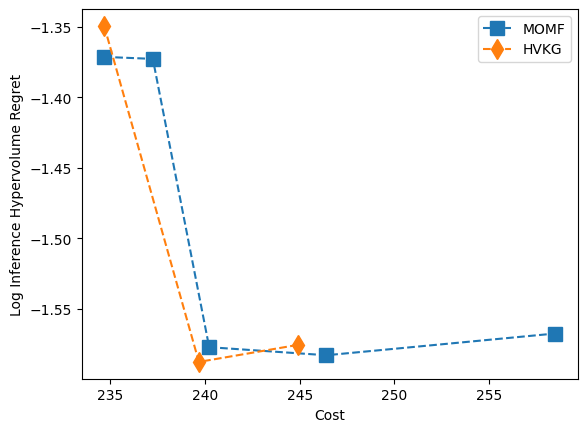

In [14]:
plt.plot(
    costs_momf,
    np.log10(BC.max_hv - np.array(hvs_momf)),
    "--",
    marker="s",
    ms=10,
    label="MOMF",
)
plt.plot(
    costs, np.log10(BC.max_hv - np.array(hvs_kg)), "--", marker="d", ms=10, label="HVKG"
)
plt.ylabel("Log Inference Hypervolume Regret")
plt.xlabel("Cost")
plt.legend()